In [7]:
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms


# **RGB->binary photo**  
### thresholding + morph transformation + resizing

In [215]:
def process(image):
    bgr = cv2.imread(image)
    gray = cv2.imread(image,cv2.IMREAD_GRAYSCALE)
    #inverse binary treshold, x=255 if x<threshold, else 0
    _,bin = cv2.threshold(gray,120,255,type=cv2.THRESH_BINARY_INV)

    #kernel morph transformation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
    #dilate the whites to make 255 colors thicker
    bin = cv2.dilate(bin,kernel)
    #resizing image form 202x202 -> 28x28
    bin = cv2.resize(bin,(28,28))
    # bin = cv2.morphologyEx(bin,cv2.MORPH_OPEN,kernel,iterations=3)
    return bin,bgr



## transforming to tensor

In [ ]:
def image2model(imgg):
    loader = transforms.Compose([transforms.ToTensor()])
    image = loader(imgg)
    image = image.unsqueeze(0)
    return image

## **loading saved model**

In [ ]:
def modeler(saved_params):
    class CNN(nn.Module):
        def __init__(self):
            super(CNN,self).__init__()
            self.conv1 = nn.Conv2d(1,8,kernel_size =(3,3),stride=(1,1),padding=(1,1))
            self.conv2 = nn.Conv2d(8,16,kernel_size =(3,3),stride=(1,1),padding=(1,1))
            self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
            self.cf1 = nn.Linear(16*7*7,10)
        
        def forward(self,x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(x.shape[0],-1)
            x = self.cf1(x)
            
            return x
    model = CNN()
    model.load_state_dict(torch.load(saved_params))
    return model
model = modeler('model.pth')


## **vizualizing the result**

In [ ]:
def view_classify(img,org_img ,ps):
    ps = F.softmax(ps,dim=1)
    ps = ps.data.numpy().squeeze()
    
    fig, (ax0,ax1, ax2) = plt.subplots(figsize=(10,30), ncols=3)
    ax0.imshow(org_img)
    ax0.set_title('original image')
    ax1.imshow(img,cmap='gray')
    ax1.set_title('binirized image')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)


# **Main function**

In [217]:
def classify(saved_model,image_path):
    bin_img, rgb_img = process(image_path)
    input_img = image2model(bin_img)
    model = modeler(saved_model)
    preds = model(input_img)
    view_classify(bin_img,rgb_img,preds)
    
    

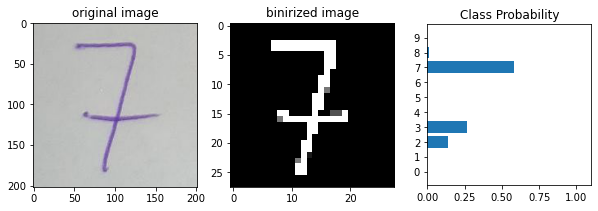

In [233]:
saved_model = 'model.pth'
image = 'images/digit/7.jpg'
classify(saved_model,image)